## This notebook demonstrates different CCG approaches

1. Jittering method
https://pubmed.ncbi.nlm.nih.gov/24741036/
2. Convolution method
https://pubmed.ncbi.nlm.nih.gov/19167428/
3. CNN model
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8187444/
4. GLM
https://www.nature.com/articles/s41467-019-12225-2
https://github.com/NII-Kobayashi/GLMCC

## Comments:

- I don't like CNN approach (#3) even though it works cause of the black box nature of it
- will compare #1, and #2 mainly. Check them with multiple params
- also add deconvolution approach to both #1 and #2 to see improvements if any
  https://www.nature.com/articles/s42003-022-03450-5

## TLDR; Final conclusion:

- Optimal params for jittering methods:
  - shuffle iteration = 1000
  - alpha = 0.001
  - jitter windows = +/- 5ms
- Deconvolution helps removing second-order statistics (bursting) from CCG and improves connection strength. However, it doesn't always work. So, might be okay to skip it for now
- Optimal params for convolution methods:
  - 10 ms gaussian window with HF=0.6
  - 10 ms median filter window with HF=1
- **Convolution methods works similar, if not better than Jittering method overall**.
- Convolution is computationally faster than Jittering method

In [1]:
import tqdm, os
import numpy as np
from ccgutils import *
import scipy.io as spio
import pynapple as nap
import matplotlib.pyplot as plt

# Load 6 CA1 simultaneously recorded units

In [2]:
dat = spio.loadmat('CA1_Data.mat')
dat = dat['CA1_Data'][0][0]

spktimes = np.ravel(dat[0])
cluid = np.ravel(dat[1])
spkfs = float(dat[2][0][0])
total_time = float(dat[3][0][0])
spktimes = spktimes/spkfs

# preprocess data
#spkts = {}
#for cid in np.unique(cluid):
#    spkts[cid] = spktimes[cluid==cid]

# using pynapple toolbox from Peyrache's lab (https://github.com/pynapple-org/pynapple)
# RUN CCG using pynapple
#epoch = nap.IntervalSet(start=0, end=total_time, time_units="s")
#spiketimes = nap.TsGroup(spkts, time_support=epoch, time_units="s")
#del spkts

## 1. Compute and plot CCG for each in +/- 30 ms window

In [3]:
# params
bin_dur = 0.0002 # 0.2 ms
win_dur = 0.05 # 50 ms
jitterMax = 0.002 # 2 ms [+/- 2ms seconds] Other papers use this
jitterMax2 = 0.005 # 5 ms [+/- 5ms seconds] Masami and Bruce's paper
shufJitterIter = 1000 # shuffle 1000times
W = int(0.01/bin_dur) # 10 ms
alpha = 0.001

In [4]:
# compute CCG
cch, t = CCG(spktimes, cluid, binSize=bin_dur, duration=win_dur, alpha=0.001)

# compute N spikes for each unit
cluid_ = np.unique(cluid)
Nspk = np.zeros_like(cluid_, dtype='int')
# Loop through each unique value in Gsub and count occurrences in spkL
for c,cid in enumerate(cluid_):
    Nspk[c] = np.sum(cluid==cid)

# unique pairs (so we can work in both forward and backward direction)
cc_pairs = np.tril_indices(cch.shape[1], k=-1)
cc_pairs = np.column_stack(cc_pairs)
# 15 unique combo for 6 units

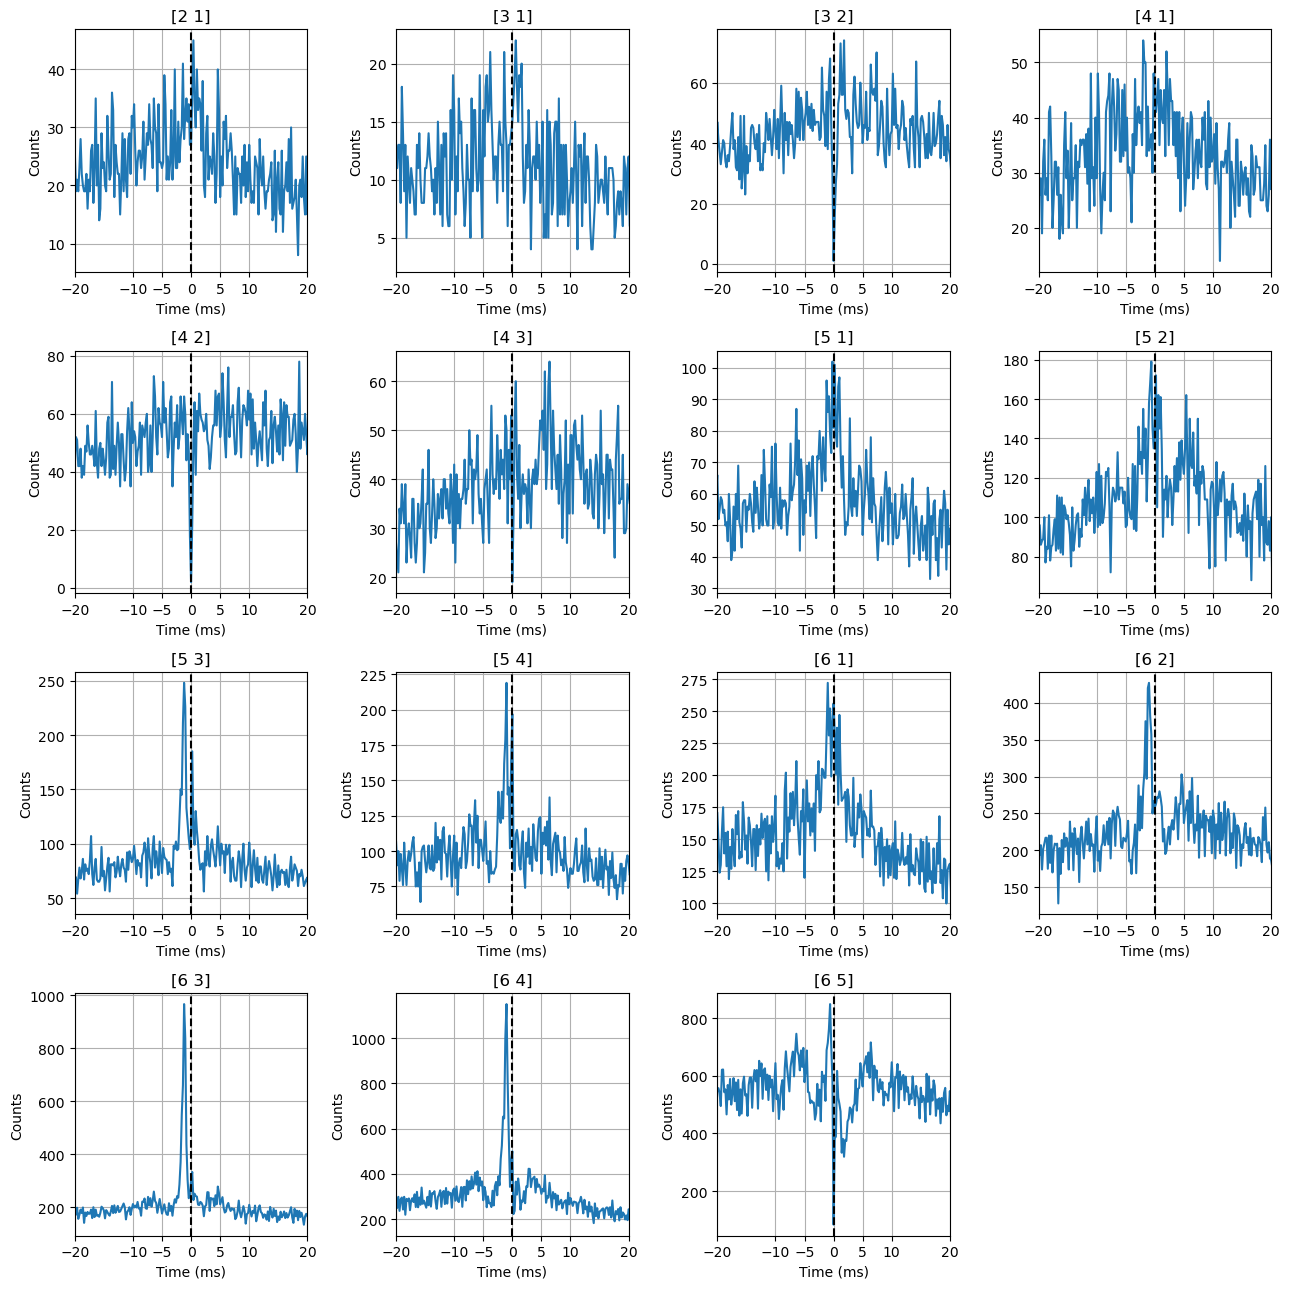

In [5]:
# plot CCG
count=1
plt.figure(figsize=(13,13))
for cc in cc_pairs:
    plt.subplot(4,4,count)
    plt.plot(t*1000, cch[:,cc[0],cc[-1]])
    plt.axvline(0, c='k', ls='--')
    plt.xticks([-20,-10,-5,0,5,10,20])
    plt.grid(True)
    plt.xlim((-20,20))
    plt.title(cluid_[cc])
    plt.xlabel('Time (ms)')
    plt.ylabel('Counts')
    count = count+1
plt.tight_layout()
plt.show()

## 2. Deconvolution to remove effect of burst spiking and other second-order spiking

In [6]:
# reshape and calculate aut0-ccorrelogram
cch, ach1, nspks1, ach2, nspks2 = CCH3D_reshape(cch, Nspk)
# deconvolution
dccch = cchdeconv(cch, ach1, nspks1, ach2, nspks2)
# reshape
cch = np.reshape(cch, [cch.shape[0],len(Nspk),len(Nspk)])
dccch = np.reshape(dccch, [dccch.shape[0],len(Nspk),len(Nspk)])

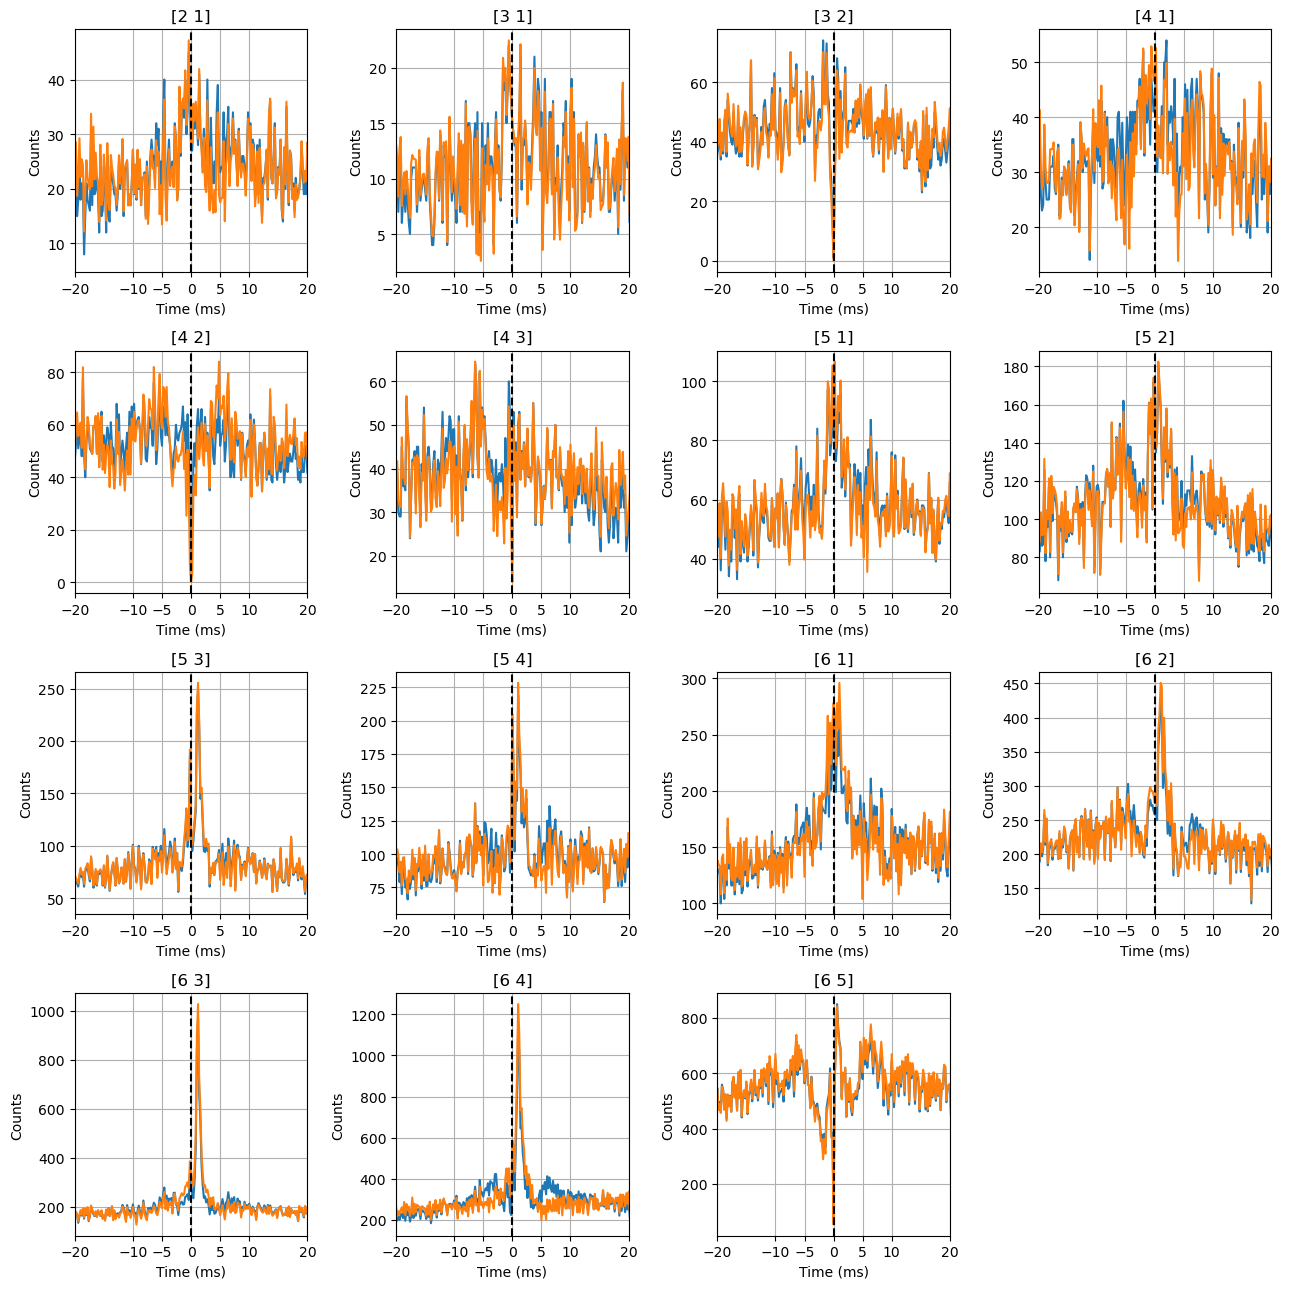

In [7]:
# plot deconvolved CCG
count=1
plt.figure(figsize=(13,13))
for cc in cc_pairs:
    plt.subplot(4,4,count)
    plt.plot(t*1000, cch[:,cc[0],cc[-1]])
    plt.plot(t*1000, dccch[:,cc[0],cc[-1]])
    plt.axvline(0, c='k', ls='--')
    plt.xticks([-20,-10,-5,0,5,10,20])
    plt.grid(True)
    plt.xlim((-20,20))
    plt.title(cluid_[cc])
    plt.xlabel('Time (ms)')
    plt.ylabel('Counts')
    count = count+1
plt.tight_layout()
plt.show()

## Take-home for deconvolution:

- Example: See (5,3) and (6,4). 
- removes bursty correlation in CCG, improve the strength calculation. However, doesn't always work
- Still not widely used, might be okay to skip it

## CCG using pynapple package from Peyrache Lab

### compute cross correlogram     
cc_func = lambda x: nap.compute_crosscorrelogram(x, binsize=bin_dur, windowsize=win_dur, reverse=True)
spks_cc = cc_func(spiketimes)
cc_pairs = spks_cc.columns.values.tolist()
t_pts = np.linspace(-win_dur*1000, win_dur*1000, spks_cc.shape[0])

### plot CCG
plt.figure(figsize=(13,13))
for c,cc in enumerate(cc_pairs):
    plt.subplot(4,4,c+1)
    plt.plot(t_pts, spks_cc[cc], c='k')
    plt.axvline(0, c='b', ls='--')
    plt.xticks([-20,-10,-5,0,5,10,20])
    plt.grid(True)
    plt.xlim((-20,20))
    plt.title(spks_cc[cc].name)
    plt.xlabel('Time (ms)')
    plt.ylabel('FR/mean_FR')
plt.tight_layout()
plt.show()

### plot CCG
plt.figure(figsize=(13,13))
for c,cc in enumerate(cc_pairs):
    plt.subplot(4,4,c+1)
    plt.plot(t_pts, spks_cc[cc], c='k')
    plt.plot(t_pts, null_ci_alpha1[1,:,c], 'r--')
    plt.plot(t_pts, null_ci2_alpha1[1,:,c], 'g--')
    #ax.fill_between(t_pts,curr_ci[0,:],curr_ci[2,:],alpha=0.2,color='k')
    plt.axvline(0, c='b', ls='--')
    plt.xticks([-20,-10,-5,0,5,10,20])
    plt.grid(True)
    plt.xlim((-20,20))
    plt.title(spks_cc[cc].name)
    plt.xlabel('Time (ms)')
    plt.ylabel('FR/mean_FR')
plt.tight_layout()
plt.show()

### null distribution for CCG
cc_null_dist = np.zeros((*spks_cc.values.shape, shufJitterIter))
cc_null_dist2 = np.zeros((*spks_cc.values.shape, shufJitterIter))
for i in tqdm.tqdm(range(shufJitterIter)):
    # kept tsupport only because end of session is 'blank'
    spks_jit = nap.jitter_timestamps(spiketimes, max_jitter=jitterMax, keep_tsupport=True)
    spks_jit2 = nap.jitter_timestamps(spiketimes, max_jitter=jitterMax2, keep_tsupport=True)
    cc_null_dist[:,:,i] = cc_func(spks_jit).values
    cc_null_dist2[:,:,i] = cc_func(spks_jit2).values

## 3. Jitter analysis

Calculate null distribution using +/- 2 ms and +/- 5 ms jitter and alpha = [0.01, 0.001] for jitter window

In [8]:
# calculate 1000 times jittered data
cc_null_dist = np.array(run_jittered_ccg(spktimes, cluid, Nspk, jitter_ms=2, binwidth=bin_dur, windowsize=win_dur, num_jitters=shufJitterIter, dodeconv=True))
cc_null_dist2 = np.array(run_jittered_ccg(spktimes, cluid, Nspk, jitter_ms=5, binwidth=bin_dur, windowsize=win_dur, num_jitters=shufJitterIter, dodeconv=True))
# transpose for ease of plotting
cc_null_dist = cc_null_dist.transpose(1, 2, 0) 
cc_null_dist2 = cc_null_dist2.transpose(1, 2, 0) 
print(cc_null_dist.shape, cc_null_dist2.shape)

# null distribution for alpha = 0.001 and 0.01 for +/- 2 ms jitter
null_ci_alpha1 = np.percentile(cc_null_dist,q=[0.001,50,99.999],axis=2)
null_ci_alpha2 = np.percentile(cc_null_dist,q=[0.01,50,99.99],axis=2)

# null distribution for alpha = 0.001 and 0.01 for +/- 5 ms jitter
null_ci2_alpha1 = np.percentile(cc_null_dist2,q=[0.001,50,99.999],axis=2)
null_ci2_alpha2 = np.percentile(cc_null_dist2,q=[0.01,50,99.99],axis=2)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 86.31it/s]


(251, 36, 1000) (251, 36, 1000)


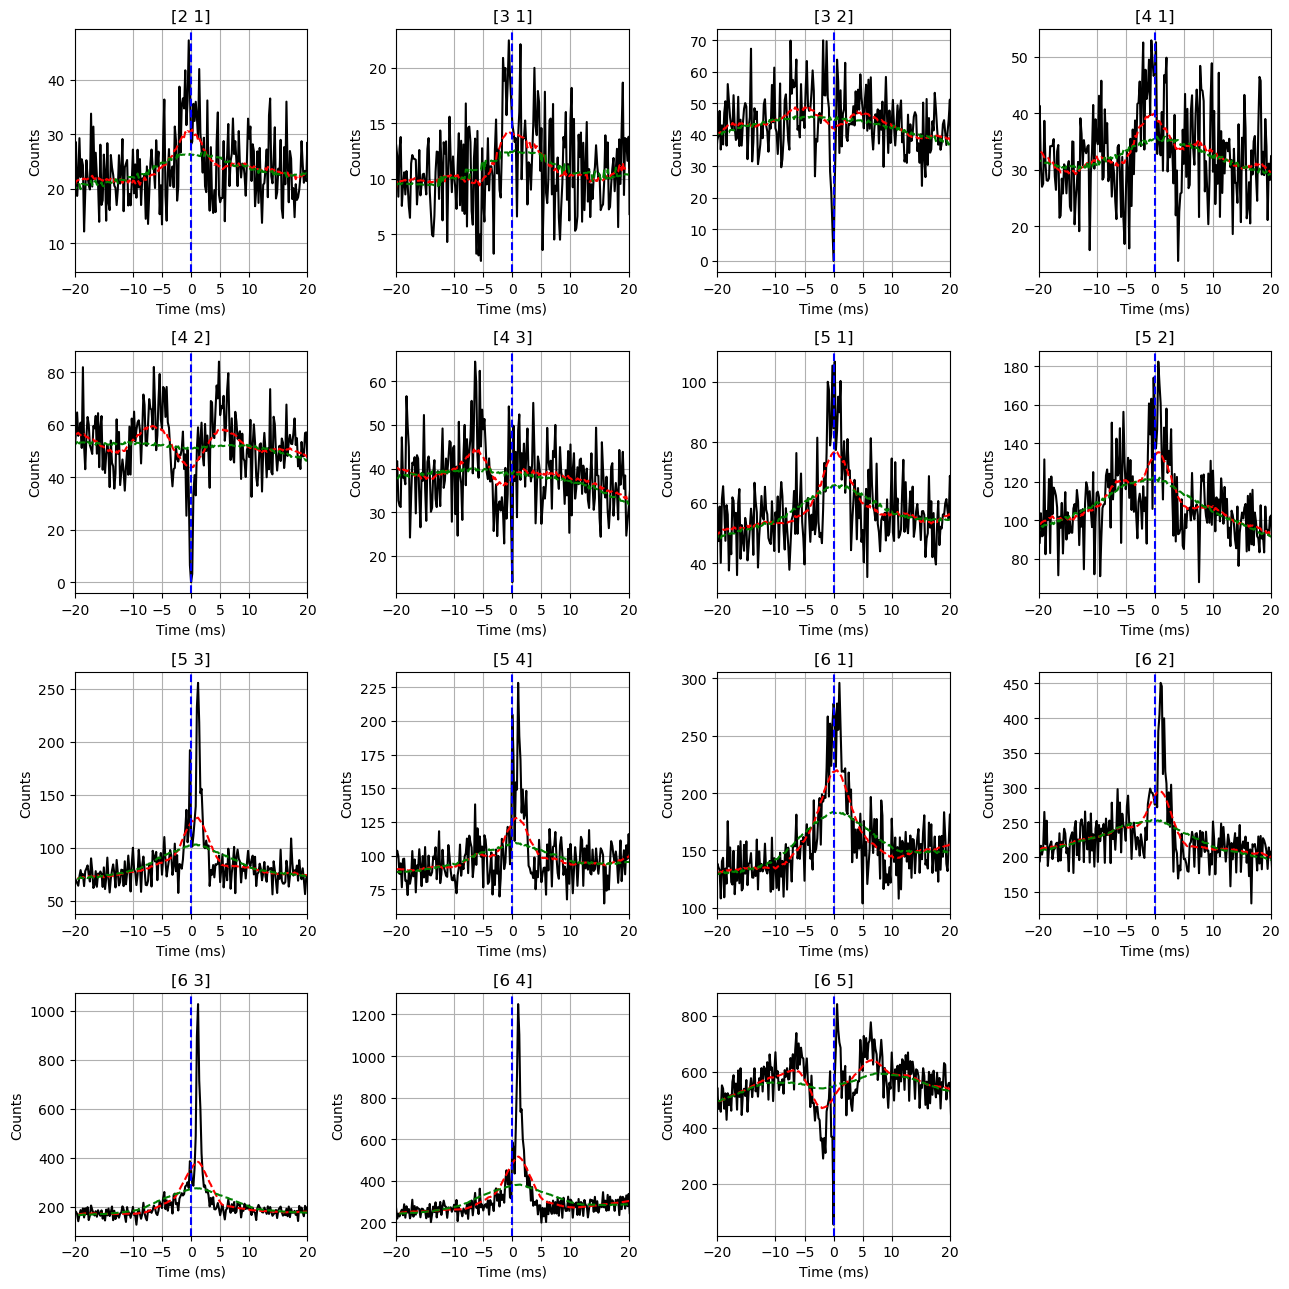

In [9]:
# plot CCG
plt.figure(figsize=(13,13))
count = 1
for cc in cc_pairs:
    plt.subplot(4,4,count)
    plt.plot(t*1000, dccch[:,cc[0],cc[1]], c='k')    
    plt.plot(t*1000, null_ci_alpha1[1,:,cc[0]*len(Nspk)+cc[1]], 'r--')
    plt.plot(t*1000, null_ci2_alpha1[1,:,cc[0]*len(Nspk)+cc[1]], 'g--')
    plt.axvline(0, c='b', ls='--')
    plt.xticks([-20,-10,-5,0,5,10,20])
    plt.grid(True)
    plt.xlim((-20,20))
    plt.title(cluid_[cc])
    plt.xlabel('Time (ms)')
    plt.ylabel('Counts')
    count = count+1
plt.tight_layout()
plt.show()

## Take-home for jitter analysis

- Use significance, alpha = 0.001 
- I'm in favor of using jitter time window should be +/- 5 ms, not because it establishes the baseline lower than +/- 2ms, but because typically CCG width for a monosynaptic connection is 2-3 ms.. So, in my mind real shuffling window should be 2x that. 

## 4. Stark & Abeles, 2009; partially-hollow gaussian kernel convolution

"We show that jittering spike trains is equivalent to convolving the CCH derived from the original trains with a finite window and using a Poisson distribution to estimate probabilities. Both procedures **over-fit the original spike trains and therefore the resulting statistical tests are biased and have low power**. 

We devise an alternative method, based on convolving the CCH with a partially hollowed window, and illustrate its utility using artificial and real spike trains. The modified **convolution method is unbiased, has high power, and is computationally fast.**"

## 5. Stark lab (Spivak et al.); partially-hollow median filter
https://www.nature.com/articles/s42003-022-03450-5

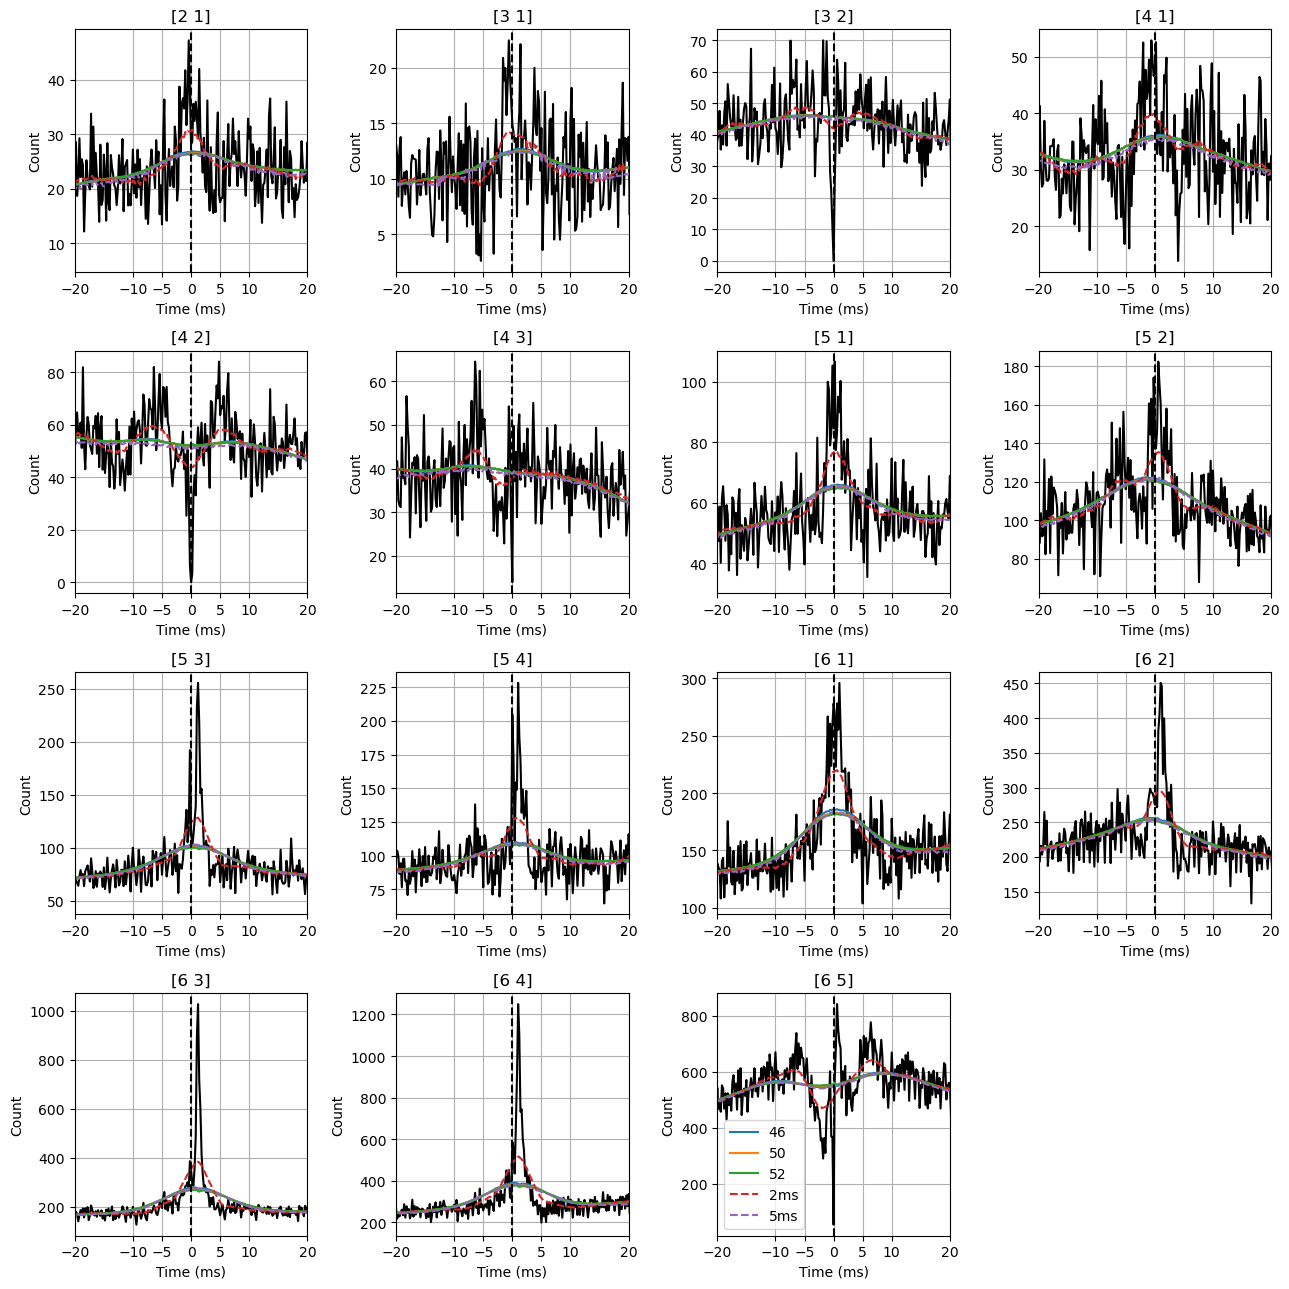

In [10]:
# plot dcCCG with partial-gaussian
plt.figure(figsize=(13,13))
for c,cc in enumerate(cc_pairs):
    plt.subplot(4,4,c+1)
    plt.plot(t*1000, dccch[:,cc[0],cc[-1]], 'k')
    for w in [46,50,52]:
         pvals, gaussian_conv, _ = cch_conv(dccch[:,cc[0],cc[-1]], w, WINTYPE='gaussian')
         plt.plot(t*1000, gaussian_conv, label=w)
    plt.plot(t*1000, null_ci_alpha1[1,:,cc[0]*len(Nspk)+cc[1]], ls='--', label='2ms')
    plt.plot(t*1000, null_ci2_alpha1[1,:,cc[0]*len(Nspk)+cc[1]], ls='--', label='5ms')
    plt.axvline(0, c='k', ls='--')
    plt.xticks([-20,-10,-5,0,5,10,20])
    plt.grid(True)
    plt.xlim((-20,20))
    plt.title(cluid_[cc])
    plt.xlabel('Time (ms)')
    plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

### looks like W=50 (10 ms window) works best. let's compare median filter vs gaussian kernel convolution

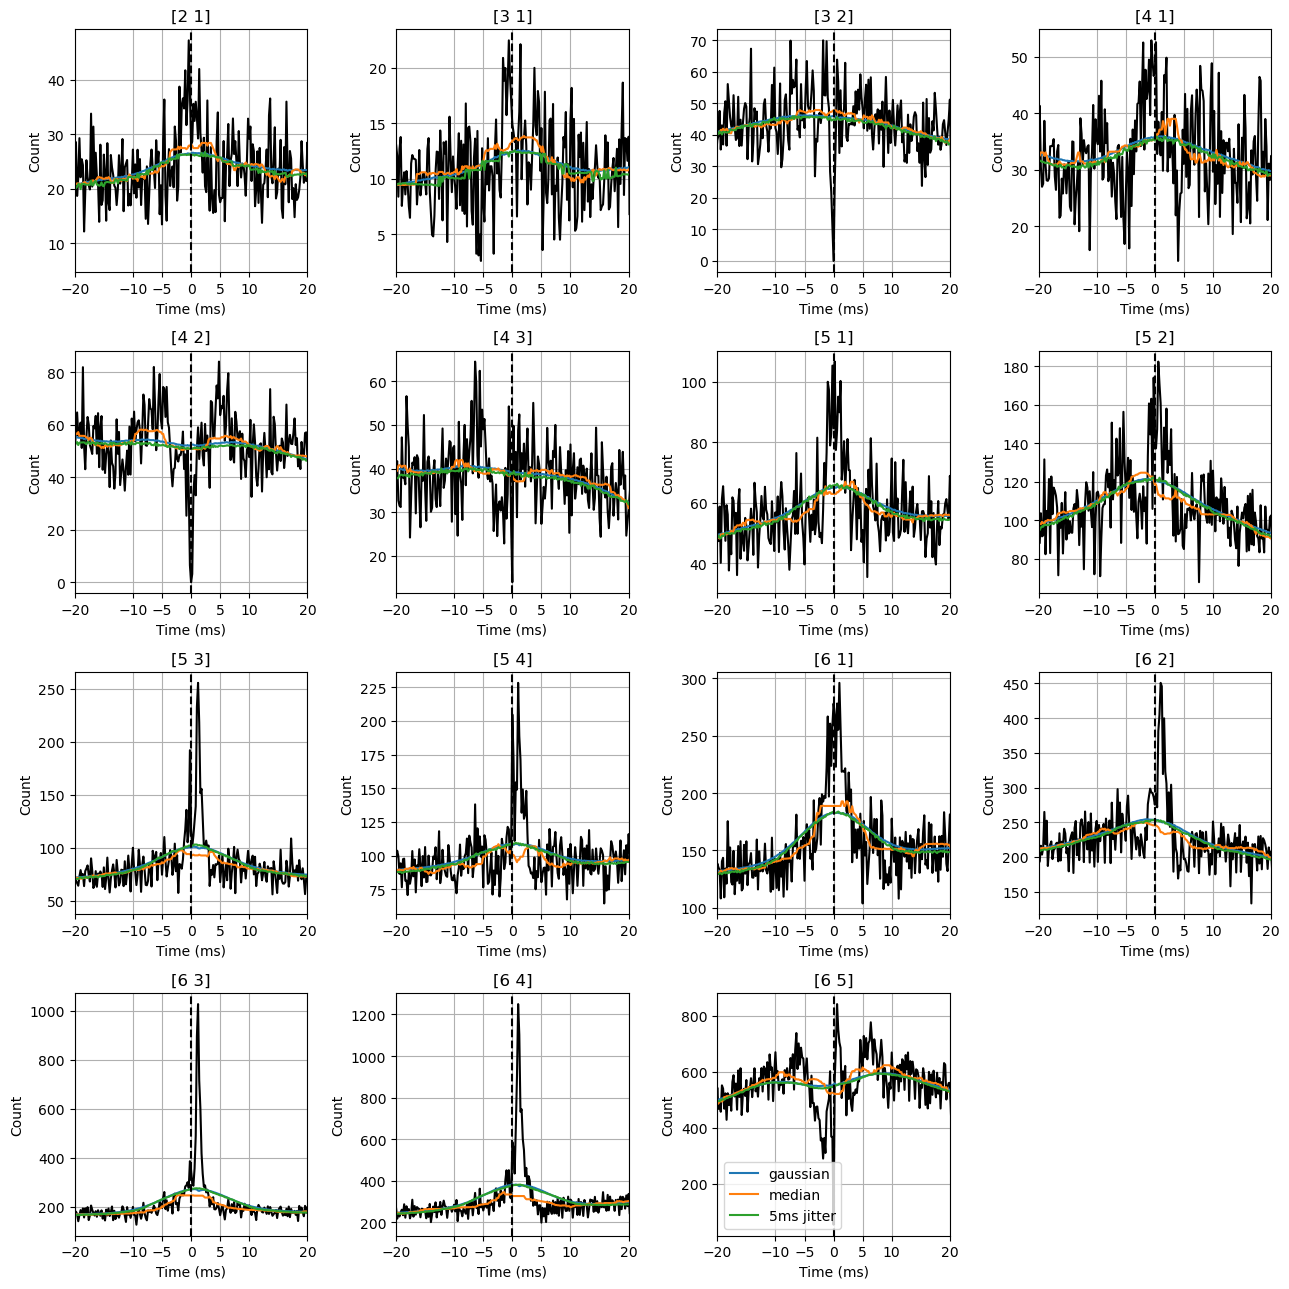

In [11]:
# plot dcCCG with partial-gaussian
plt.figure(figsize=(13,13))
for c,cc in enumerate(cc_pairs):
    plt.subplot(4,4,c+1)
    plt.plot(t*1000, dccch[:,cc[0],cc[-1]], 'k')
    _, gaussian_conv, _ = cch_conv(dccch[:,cc[0],cc[-1]], W, WINTYPE='gaussian')
    plt.plot(t*1000, gaussian_conv, label='gaussian')
    _, median_conv, _ = cch_conv(dccch[:,cc[0],cc[-1]], W, WINTYPE='median')
    plt.plot(t*1000, median_conv, label='median')
    plt.plot(t*1000, null_ci2_alpha1[1,:,cc[0]*len(Nspk)+cc[1]], label='5ms jitter')
    plt.axvline(0, c='k', ls='--')
    plt.xticks([-20,-10,-5,0,5,10,20])
    plt.grid(True)
    plt.xlim((-20,20))
    plt.title(cluid_[cc])
    plt.xlabel('Time (ms)')
    plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

## Take-home message for unbiased-convolution approaches

- Comparing to +/- 5ms jitter:
  - Optimal param for partially-hollow (HF = 0.6) gaussian kernel is window size = 10ms (W=25 above); used in McKenzie and Dan English paper, Other Buzsaki lab paper
  - Optimal param for partially-hollow (HF=1) median filter is window size = 10 ms (W=50)
  - Overall, median filter works better than gaussian-kernel. However, few failures points are there
  - Both are computationally fast
- **Suggestion: replace jittering method with Median filter**

## 6. Tests for significance boundaries

In [12]:
# create artificial reciprocal E-I connection
cch[100:125,3,5] = cch[100:125,3,5]-100
cch[126:150,3,5] = cch[126:150,3,5]+100

# create artificial reciprocal E-E connection
cch[100:125,2,5] = np.flipud(cch[125:150,2,5])

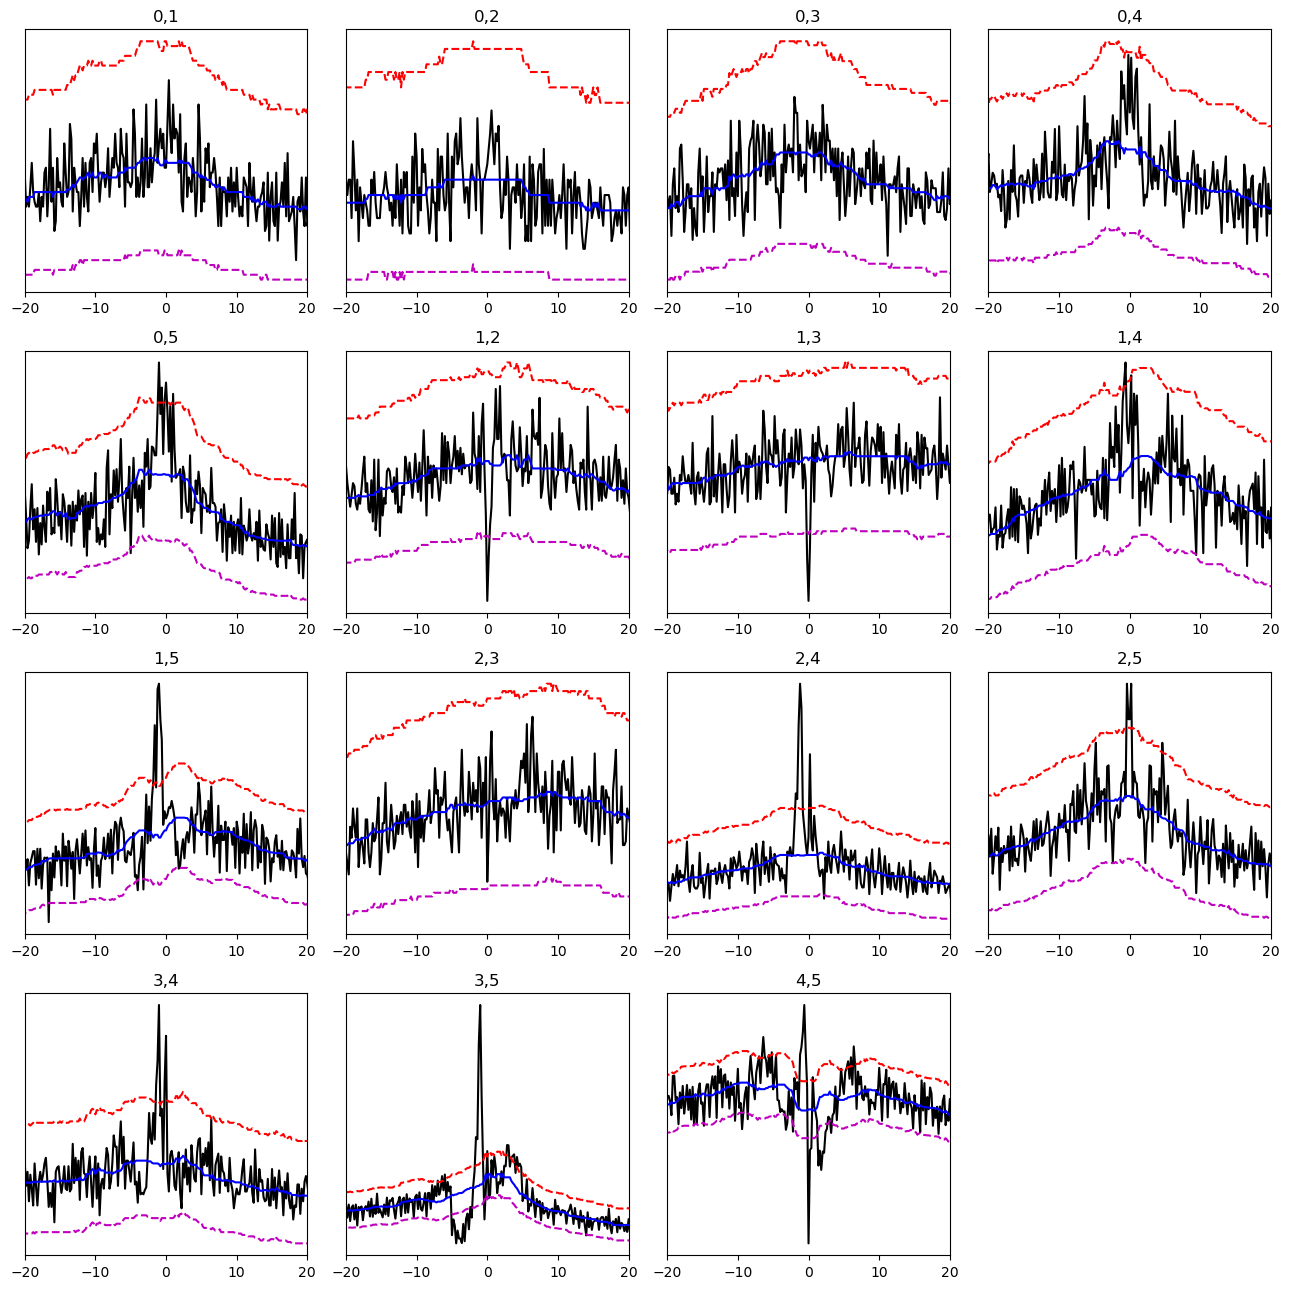

In [13]:
# run ccg significance estimation
nCells = len(Nspk)
Pval, Pred, Bounds, sig_con, sig_con_inh, Pcausal, Pcausal_inh, syn_strength, syn_ratio, syn_strength_inh, syn_ratio_inh = ccg_sig_continuity(cch, t, nCells, WINTYPE='median', bin_dur=0.0002, 
                                                                                                                                              min_win_monosyn = 0.004, alpha = 0.001)

# plot CCG with significance bounds
count = 1 
plt.figure(figsize=(13,13))
for refcid in range(nCells):
    for targetcid in range(refcid+1,nCells):
        plt.subplot(4,4,count)
        plt.plot(t*1000, cch[:,refcid,targetcid], c='k')
        plt.plot(t*1000, Pred[:,refcid,targetcid], c='b')
        plt.plot(t*1000, Bounds[:,refcid,targetcid,0], 'r--')
        plt.plot(t*1000, Bounds[:,refcid,targetcid,1], 'm--')
        plt.xlim([-20,20])
        plt.yticks([])
        plt.title(str(refcid)+','+str(targetcid))
        count = count+1
plt.tight_layout()
plt.show()

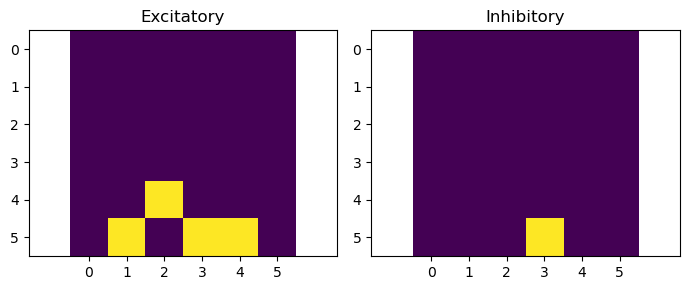

In [14]:
# plot excitatory plus inhibitory connection
plt.figure(figsize=(7,3))
plt.subplot(121)
plt.imshow(Pcausal<alpha)
plt.xticks(np.arange(nCells))
plt.axis('equal')
plt.title('Excitatory')
plt.subplot(122)
plt.imshow(Pcausal_inh<alpha)
plt.xticks(np.arange(nCells))
plt.title('Inhibitory')
plt.axis('equal')
plt.tight_layout()
plt.show()

## Take-home

- Notice the **failure of poisson continuity correction used extensively in detecting reciprocal E-E connections**. Example [3,6] CCG.. no peaks in connection matrix
- Works well for unidirectional connection and rejecting common input connections ([0-4], [0-5])
- For reciprocal connection  (2,5) -> prebins should not be (-0.004-0) ms. How abt changing it to -0.014 ms to -0.01 ms. 

## New dataset 
https://github.com/dbheadley/mimo_pack/blob/main/tutorials/AnalyzeMonosynapticCC.ipynb

In [15]:
# load spiketimes and cluster id
spkfs = 30000.0
cluid = np.ravel(np.load('spike_clusters.npy', allow_pickle=True))
cluid = cluid+1 # HACK to make it work matching matlab 
spktimes = np.ravel(np.load('spike_times.npy', allow_pickle=True))
spktimes = spktimes/spkfs

In [16]:
# compute CCG
cch, t = CCG(spktimes, cluid, binSize=bin_dur, duration=win_dur, alpha=0.001)

# compute N spikes for each unit
cluid_ = np.unique(cluid)
Nspk = np.zeros_like(cluid_, dtype='int')
# Loop through each unique value in Gsub and count occurrences in spkL
for c,cid in enumerate(cluid_):
    Nspk[c] = np.sum(cluid==cid)

# unique pairs (so we can work in both forward and backward direction)
cc_pairs = np.tril_indices(cch.shape[1], k=-1)
cc_pairs = np.column_stack(cc_pairs)
print(len(cc_pairs))

105


In [17]:
# calculate 1000 times jittered data
cc_null_dist = np.array(run_jittered_ccg(spktimes, cluid, Nspk, jitter_ms=5, binwidth=bin_dur, windowsize=win_dur, num_jitters=shufJitterIter))
cc_null_dist = cc_null_dist.transpose(1, 2, 0) 
# null distribution for alpha = 0.001 and 0.01 for +/- 5 ms jitter
null_ci_alpha = np.percentile(cc_null_dist,q=[0.001,50,99.999],axis=2)

# run ccg significance estimation
nCells = len(Nspk)
Pval, Pred, Bounds, sig_con, sig_con_inh, Pcausal, Pcausal_inh, syn_strength, syn_ratio, syn_strength_inh, syn_ratio_inh = ccg_sig_continuity(cch, t, nCells, WINTYPE='median', bin_dur=0.0002, 
                                                                                                                                              min_win_monosyn = 0.004, alpha = 0.001)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 52.85it/s]


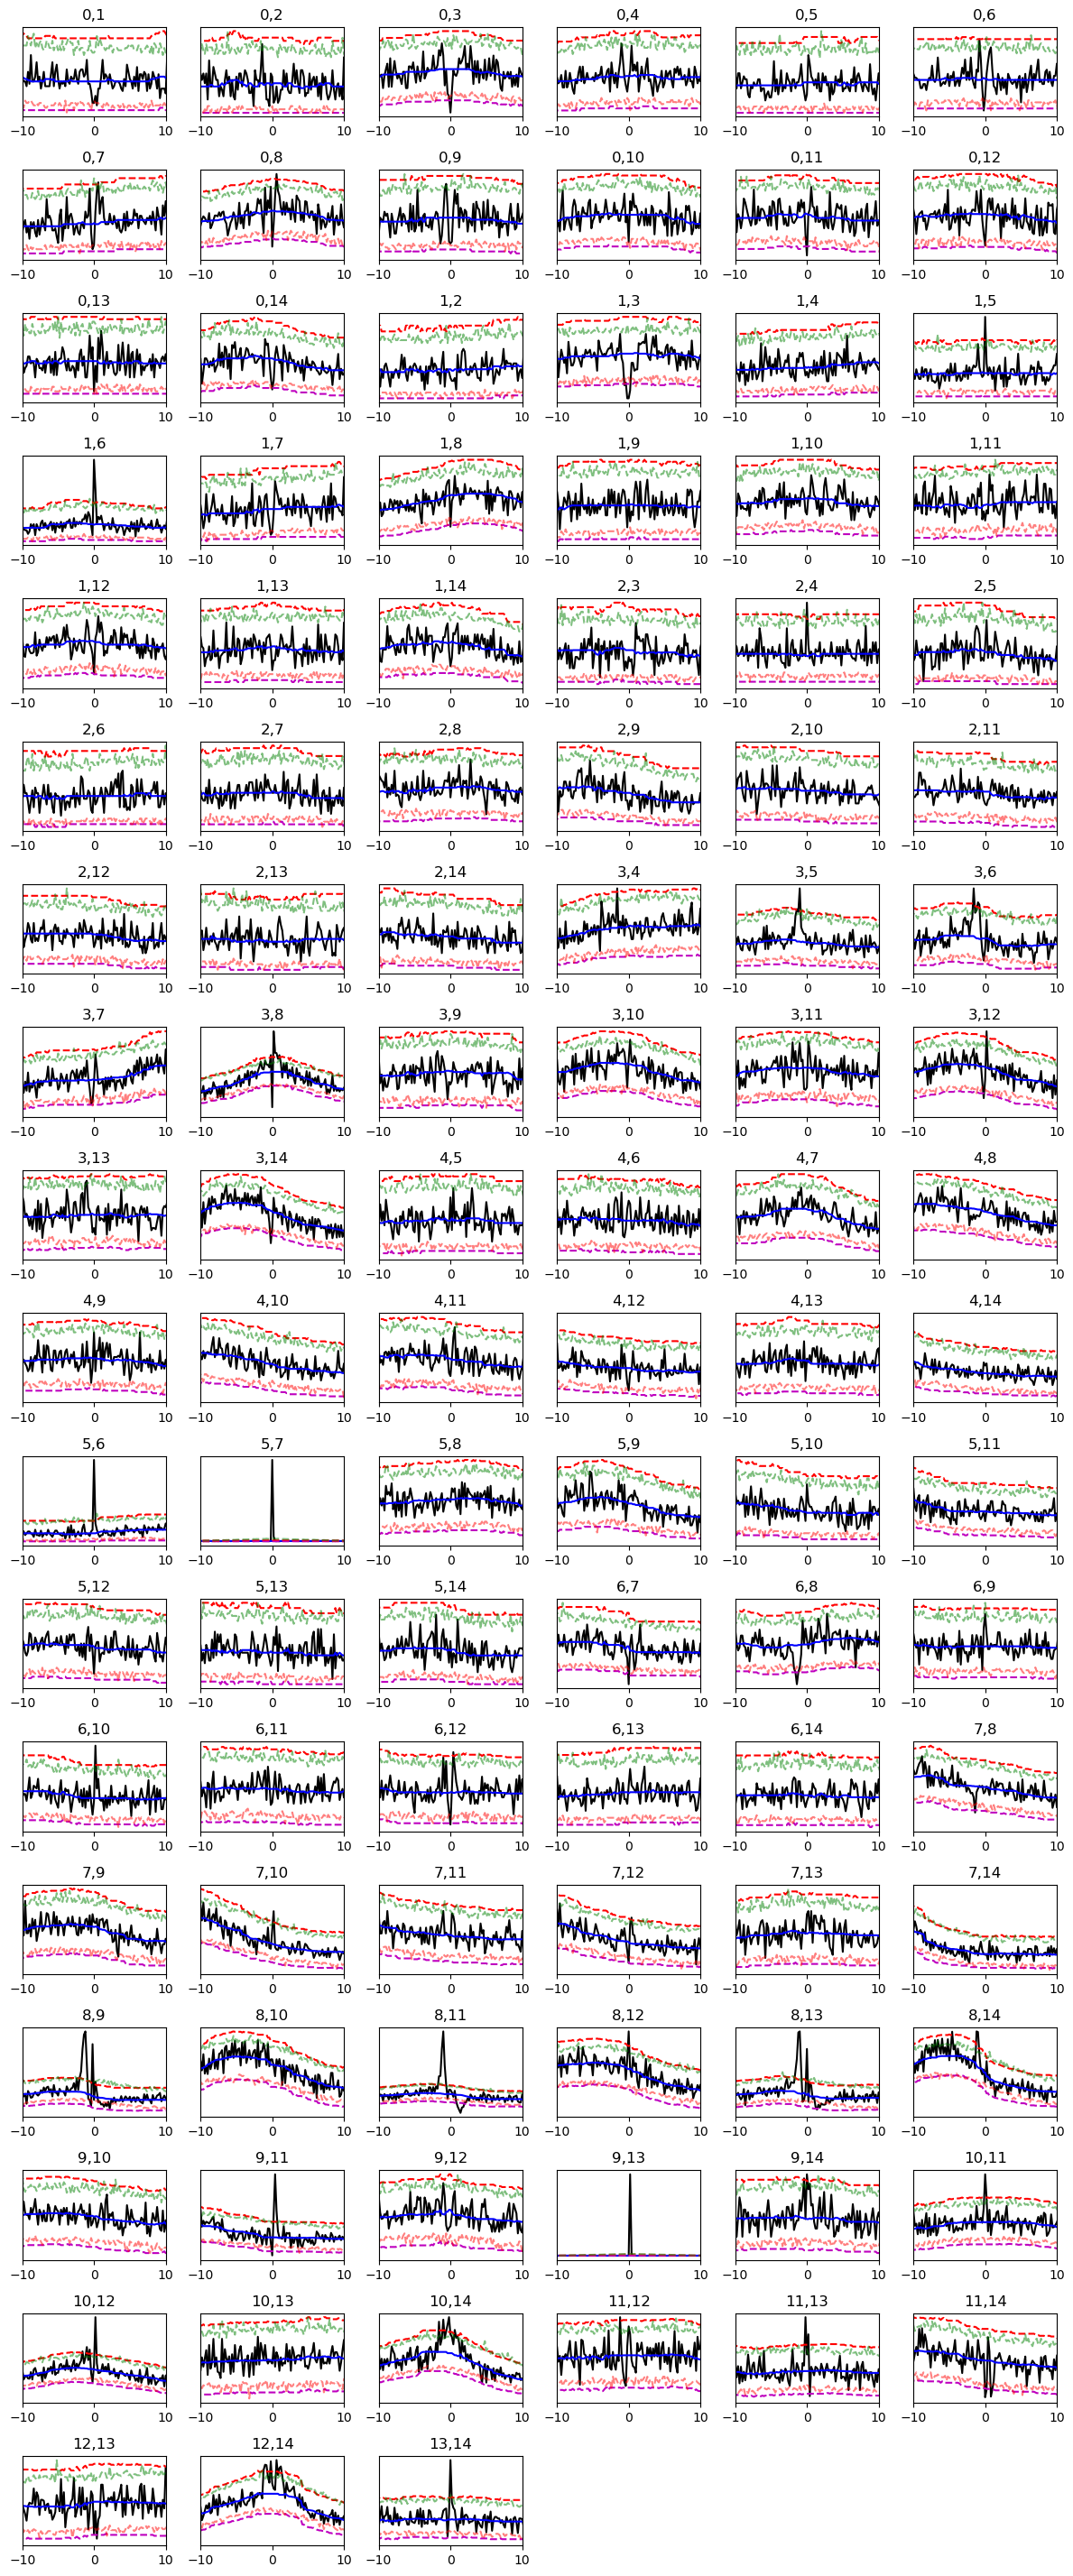

In [18]:
# plot CCG with significance bounds
count = 1 
plt.figure(figsize=(12,30))
for refcid in range(nCells):
    for targetcid in range(refcid+1,nCells):
        plt.subplot(19,6,count)
        plt.plot(t*1000, cch[:,refcid,targetcid], c='k')
        plt.plot(t*1000, Pred[:,refcid,targetcid], c='b')
        plt.plot(t*1000, Bounds[:,refcid,targetcid,0], 'r--')
        plt.plot(t*1000, Bounds[:,refcid,targetcid,1], 'm--')
        plt.plot(t*1000, null_ci_alpha[0,:,targetcid*len(Nspk)+refcid], color='r', ls='--', alpha=0.5)
        plt.plot(t*1000, null_ci_alpha[2,:,targetcid*len(Nspk)+refcid], color='g', ls='--', alpha=0.5)
        plt.xlim([-10,10])
        plt.yticks([])
        plt.title(str(refcid)+','+str(targetcid))
        count = count+1
plt.tight_layout()
plt.show()

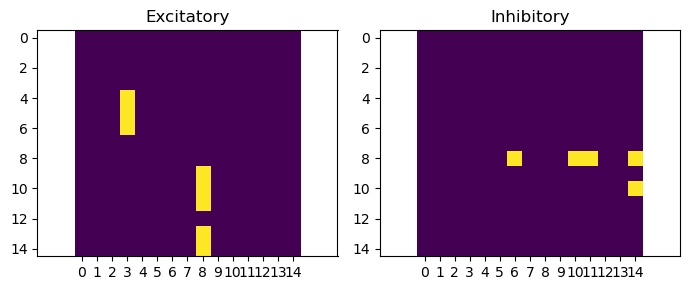

In [19]:
# plot excitatory plus inhibitory connection
plt.figure(figsize=(7,3))
plt.subplot(121)
plt.imshow(Pcausal<alpha)
plt.xticks(np.arange(nCells))
plt.axis('equal')
plt.title('Excitatory')
plt.subplot(122)
plt.imshow(Pcausal_inh<alpha)
plt.xticks(np.arange(nCells))
plt.title('Inhibitory')
plt.axis('equal')
plt.tight_layout()
plt.show()